# 06 - Restart Wrappers & CMA-ES Variants
### [Last Update: March 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/06_restart_es.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q git+https://github.com/RobertTLange/evosax.git@main

## Restart Open-ES on CartPole when Fitness "Converges"
### Double Population Size Each Time!

In [7]:
import jax
import jax.numpy as jnp

from evosax import OpenES, ParameterReshaper, FitnessShaper, NetworkMapper
from evosax.utils import ESLog
from evosax.problems import GymFitness

rng = jax.random.PRNGKey(0)
network = NetworkMapper["MLP"](
    num_hidden_units=32,
    num_hidden_layers=2,
    num_output_units=2,
    hidden_activation="relu",
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
params = network.init(
    rng,
    x=pholder,
    rng=rng,
)

param_reshaper = ParameterReshaper(params)

ParameterReshaper: 1282 parameters detected for optimization.


In [8]:
evaluator = GymFitness("CartPole-v1", num_env_steps=200, num_rollouts=16)
evaluator.set_apply_fn(param_reshaper.vmap_dict, network.apply)

In [12]:
from evosax.restarts import IPOP_Restarter

# Define a termination criterion (kwargs - fitness, state, params)
def std_criterion(fitness, state, params):
    """Restart strategy if fitness std across population is small."""
    # Make sure that you don't use centered ranks/z-scoring here :)
    return fitness.std() < 2

base_strategy = OpenES(popsize=100, num_dims=param_reshaper.total_params)

strategy = IPOP_Restarter(base_strategy, stop_criteria=[std_criterion])
es_params = strategy.default_params
es_params  # popsize_multiplier - controls increase at each restart

WrapperParams(strategy_params=EvoParams(opt_params=OptParams(lrate_init=0.01, lrate_decay=0.999, lrate_limit=0.001, momentum=None, beta_1=0.99, beta_2=0.999, eps=1e-08, max_speed=None), sigma_init=0.04, sigma_decay=0.999, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38), restart_params=RestartParams(min_num_gens=50, min_fitness_spread=1e-12, popsize_multiplier=2, copy_mean=False))

In [13]:
# Set option to copy over mean between resets - for OpenES only resets sigma!
es_params = es_params.replace(restart_params=es_params.restart_params.replace(copy_mean=True))
es_params

WrapperParams(strategy_params=EvoParams(opt_params=OptParams(lrate_init=0.01, lrate_decay=0.999, lrate_limit=0.001, momentum=None, beta_1=0.99, beta_2=0.999, eps=1e-08, max_speed=None), sigma_init=0.04, sigma_decay=0.999, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38), restart_params=RestartParams(min_num_gens=50, min_fitness_spread=1e-12, popsize_multiplier=2, copy_mean=True))

In [14]:
num_generations = 200
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(centered_rank=False,
                           z_score=False,
                           w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng, es_params)

restart_gens = []

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    if state.restart_state.restart_next:
        restart_gens.append(gen)
        print(f"--> Restarted Strategy: Gen {gen}")
        print_update = True
    else:
        print_update = False
    x, state = strategy.ask(rng_ask, state, es_params)
    if print_update:
        print(f"--> New Popsize: {state.restart_state.active_popsize}")
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Perf (Best): ", log["log_top_1"][gen], "Perf (Mean): ", fitness.mean(), fitness.std())

Generation:  0 Perf (Best):  25.3125 Perf (Mean):  22.210625 0.89572144
Generation:  20 Perf (Best):  28.0625 Perf (Mean):  19.783125 0.8995422
Generation:  40 Perf (Best):  28.0625 Perf (Mean):  21.81625 0.46944278
--> Restarted Strategy: Gen 50
--> New Popsize: 200
Generation:  60 Perf (Best):  30.875 Perf (Mean):  18.859375 0.8144148
Generation:  80 Perf (Best):  31.875 Perf (Mean):  22.13125 0.83103853
Generation:  100 Perf (Best):  41.875 Perf (Mean):  24.884687 1.4744185
--> Restarted Strategy: Gen 101
--> New Popsize: 400
Generation:  120 Perf (Best):  61.5 Perf (Mean):  36.045624 5.693629
Generation:  140 Perf (Best):  108.25 Perf (Mean):  79.3975 9.712329
Generation:  160 Perf (Best):  176.25 Perf (Mean):  139.6253 18.515297
Generation:  180 Perf (Best):  200.0 Perf (Mean):  173.19374 9.615619
--> Restarted Strategy: Gen 189
--> New Popsize: 800


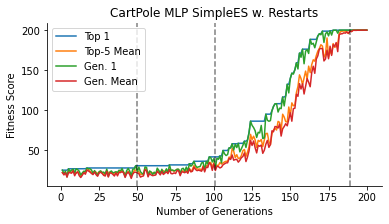

In [15]:
fig, ax = es_logging.plot(log, "CartPole MLP SimpleES w. Restarts")
for i in restart_gens:
    ax.axvline(i, c="black", ls="--", alpha=0.5)

## BIPOP-CMA-ES

In [31]:
from evosax import BIPOP_CMA_ES

strategy = BIPOP_CMA_ES(popsize=100,
                        num_dims=param_reshaper.total_params,
                        elite_ratio=0.5)
es_params = strategy.default_params.replace(
        restart_params=strategy.default_params.restart_params.replace(
            min_fitness_spread=1)
        )
es_params

WrapperParams(strategy_params=EvoParams(mu_eff=DeviceArray(26.966648, dtype=float32), c_1=DeviceArray(1.2144131e-06, dtype=float32), c_mu=DeviceArray(3.0331763e-05, dtype=float32), c_sigma=DeviceArray(0.02204519, dtype=float32), d_sigma=DeviceArray(1.0220451, dtype=float32), c_c=DeviceArray(0.00312667, dtype=float32), chi_n=DeviceArray(35.798042, dtype=float32), c_m=1.0, sigma_init=0.065, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38), restart_params=RestartParams(min_num_gens=50, min_fitness_spread=1, popsize_multiplier=2, tol_x=1e-12, tol_x_up=10000.0, tol_condition_C=100000000000000.0))

In [8]:
# Use single device due to odd/even popsizes -> makes it hard to make sure even division
param_reshaper = ParameterReshaper(params, n_devices=1)
evaluator = GymFitness("CartPole-v1", num_env_steps=200, num_rollouts=16, n_devices=1)
evaluator.set_apply_fn(param_reshaper.vmap_dict, network.apply)

In [9]:
num_generations = 600
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng, es_params)

restart_gens = []

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    if state.restart_state.restart_next:
        restart_gens.append(gen)
        print(f"--> Restarted Strategy: Gen {gen}")
        print_update = True
    else:
        print_update = False
    x, state = strategy.ask(rng_ask, state, es_params)
    if print_update:
        print(f"--> New Popsize: {state.restart_state.active_popsize}")
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Perf (Best): ", log["log_top_1"][gen], "Perf (Mean): ", fitness.mean())

Generation:  0 Perf (Best):  24.1875 Perf (Mean):  21.789375
Generation:  20 Perf (Best):  29.5625 Perf (Mean):  20.15625
Generation:  40 Perf (Best):  29.5625 Perf (Mean):  21.512499
Generation:  60 Perf (Best):  31.5625 Perf (Mean):  17.129375
Generation:  80 Perf (Best):  33.75 Perf (Mean):  24.57625
Generation:  100 Perf (Best):  53.4375 Perf (Mean):  31.818748
Generation:  120 Perf (Best):  130.8125 Perf (Mean):  76.581245
Generation:  140 Perf (Best):  200.0 Perf (Mean):  171.45375
Generation:  160 Perf (Best):  200.0 Perf (Mean):  199.22499
--> Restarted Strategy: Gen 180
--> New Popsize: 200
Generation:  180 Perf (Best):  200.0 Perf (Mean):  19.42125
Generation:  200 Perf (Best):  200.0 Perf (Mean):  20.525936
Generation:  220 Perf (Best):  200.0 Perf (Mean):  20.189062
Generation:  240 Perf (Best):  200.0 Perf (Mean):  23.519999
Generation:  260 Perf (Best):  200.0 Perf (Mean):  21.384375
Generation:  280 Perf (Best):  200.0 Perf (Mean):  21.339375
Generation:  300 Perf (Best)

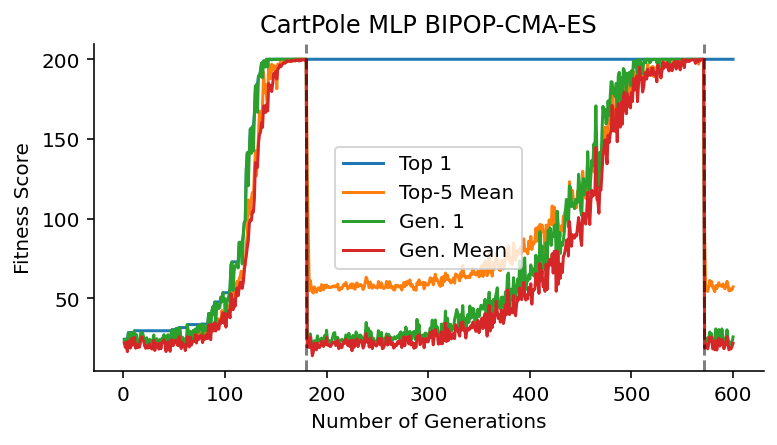

In [10]:
fig, ax = es_logging.plot(log, "CartPole MLP BIPOP-CMA-ES")
for i in restart_gens:
    ax.axvline(i, c="black", ls="--", alpha=0.5)